# Hackathon - Quelle(s) énergie(s) pour demain ?

Dans cette étude, nous essayons de mettre en évidence une relation entre la consommation et la production d'énergie en France avec les investissements publics en R&D dans le domaine de l'énergie.

*Sources*:
 - data.gouv.fr

## Plan

 1. Etat des lieux
  - Consommation par secteur
  - Production énergétique
 2. Investissement R&D en France dans le domaine de l'énergie
 3. Tentative de corrélation entre investissements R&D et production d'énergie dans le domaine du renouvelable
 


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import itertools
from bs4 import BeautifulSoup
import requests

plt.rcParams['figure.figsize'] = [20, 12]

## Etat des lieux

### Consommation par secteur

In [2]:
df_01 = pd.read_excel('data/series-longues-bilan-energetique-2018-donnees-provisoires-revisees-au-16-10-2019.xls')

In [3]:
# clean data
df_clean = df_01[df_01['LIBSERIE'].str.contains("Consommation|consommation")].copy()

df_clean = df_clean[df_clean['NIVGEO'].str.contains("Métropole")]

targets = ['industrie', 'tertiaire', 'résidentiel', 'transport', 'agriculture']

df_clean = df_clean[df_clean['LIBSERIE'].str.contains('finale')]

df_clean = df_clean[df_clean['LIBSERIE']
                    .apply(lambda sentence: any(word in sentence for word in targets))]

df_clean = df_clean[~df_clean['TYPFLUX'].str.contains('Résidentiel-tertiaire|Résidentiel-Tertiaire|Consommation finale')]

df_clean = df_clean[df_clean['TYPDONNEE'] == 'Réelles']

df_clean = df_clean[~df_clean['ENERGIE'].str.contains('Chaleur vendue|Toutes énergies')]

df_clean = df_clean[df_clean['UNITE'] == 'Mtep']

df_clean = df_clean[~df_clean['LIBSERIE'].str.contains('aérien|routier|ferroviaire|maritime')]

# df_clean.head()

In [4]:
dffinal = df_clean.groupby(['TYPFLUX', 'ENERGIE']).sum()

columns = [str(i) for i in range(1990, 2018)]

dffinal = dffinal[columns]

# dffinal.head()

In [5]:
dftest = dffinal.transpose()

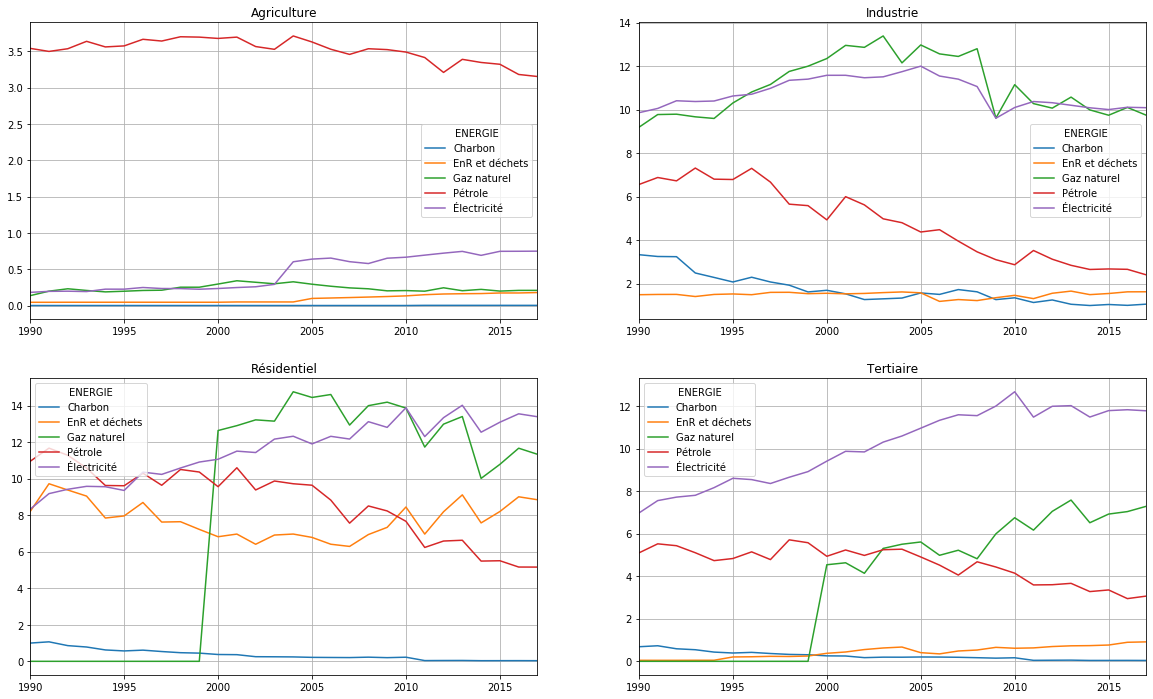

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for e, ax in zip(dftest.columns.get_level_values(0).unique(), axes.reshape(-1)):
    dftest[e].plot(ax=ax)
    ax.grid()
    ax.set_title(e)
    
plt.show()

### Production énergétique en France

In [7]:
excel = pd.ExcelFile("data/series-longues-bilan-energetique-2018-donnees-provisoires-revisees-au-16-10-2019.xls")

df_02 = pd.read_excel(excel)

In [8]:
# Select production e
production_elec = df_02[(df_02["LIBSERIE"].str.contains("Production nette d'électricité"))\
                        & (df_02["NIVGEO"] == "Métropole")\
                        & (df_02["UNITE"] == "Mtep")].rename(columns={"LIBSERIE":"Type de production"})

In [9]:
columns = [str(i) for i in range(1990, 2019)]
columns +=["Type de production"]
production_elec = production_elec[columns]

# transpose
production_elec = production_elec.set_index("Type de production").transpose().dropna(axis=1)

<Figure size 1080x720 with 0 Axes>

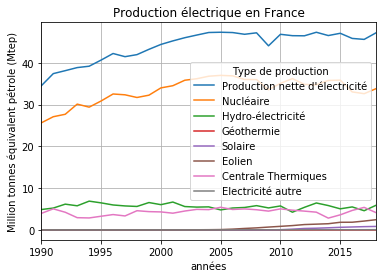

In [10]:
nommage_colonne = {"Production nette d'électricité hydraulique (y compris pompages)":"Hydro-électricité",
                   "Production nette d'électricité géothermique":"Géothermie",
                   "Production nette d'électricité solaire photovoltaïque":"Solaire",
                   "Production nette d'électricité éolienne": "Eolien",
                   "Production nette d'électricité des centrales thermiques classiques": "Centrale Thermiques",
                   "Production nette d'électricité, autres sources": "Electricité autre",
                   "Production nette d'électricité nucléaire":"Nucléaire"
                  }

production_elec = production_elec.rename(columns=nommage_colonne)

# display
fig = plt.figure(figsize=(15, 10))

production_elec.plot()

plt.grid()
plt.title("Production électrique en France")
plt.xlabel("années")
plt.ylabel("Million tonnes équivalent pétrole (Mtep)")

plt.show()

In [11]:
consomation_finale = df_02[(df_02["NIVGEO"] == "Métropole") \
                           & (df_02["UNITE"] == "Mtep") \
                           & (df_02["TYPFLUX"]=="Consommation finale")
                           & df_02["ENERGIE"].str.contains("Charbon|Électricité|EnR et déchets|Gaz naturel|Pétrole") \
                           & (df_02["TYPDONNEE"]=="Réelles") ].rename(columns={"LIBSERIE":"Type de production"})
#consomation_finale

In [12]:
consomation_finale = consomation_finale[columns]
consomation_finale.fillna(0)
consomation_finale = consomation_finale.set_index("Type de production").transpose()

In [13]:
total = consomation_finale.join(production_elec)

nommage_colonne = {
    "Consommation finale de charbon, tous usages confondus": "Charbon",
    "Consommation finale d'énergies renouvelables thermiques et déchets, tous usages confondus": "Biomasse et déchets",
    "Consommation finale de gaz naturel, tous usages confondus": "Gaz naturel",
    "Consommation finale de produits raffinés, tous usages confondus": "Pétrole"
}
total = total.rename(columns=nommage_colonne)
total = total.drop(columns=["Production nette d\'électricité","Consommation finale d\'électricité, tous usages confondus"] )

<Figure size 1080x720 with 0 Axes>

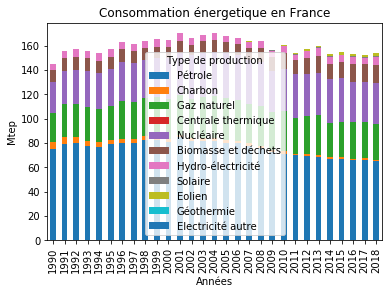

In [14]:
#total.plot(kind='bar', stacked=True)

select_cols = ['Pétrole', 'Charbon', 'Gaz naturel', 'Centrale thermique', 'Nucléaire',
               'Biomasse et déchets', 'Hydro-électricité', 'Solaire', 'Eolien', 'Géothermie', 'Electricité autre']

fig = plt.figure(figsize=(15, 10))
total.reindex(columns=select_cols).plot(kind='bar', stacked=True)

plt.title("Consommation énergetique en France")
plt.xlabel("Années")
plt.ylabel("Mtep")

plt.show()

In [15]:
renouvelable = total[["Biomasse et déchets",
                      "Hydro-électricité", "Géothermie", "Solaire", "Eolien"]]

## Dépense R&D public dans le domaine de l'énergie

Nous avons cherché des données sur les investissements privés en R&D dans le domaine de l'énergie.
Malheureusement nous n'avons pas trouvé de données consolidées au niveau national.

In [16]:
df = pd.read_excel('data/depPubRD2018.xls',
                   sheet_name='R&D Nomenclature AIE',  skiprows=2)

In [17]:
df.rename(columns={'Unnamed: 0': 'Level 1',
                   'Unnamed: 1': 'Level 2',
                   'Unnamed: 2': 'Level 3',
                   'Unnamed: 3': 'Level 4'}, inplace=True)

In [18]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [19]:
df['is_level1'] = ~df.iloc[:, 0].isnull()
df['is_level2'] = ~df.iloc[:, 1].isnull()
df2 = df[(df['is_level1'] == True) | (df['is_level2'] == True)].copy()

In [20]:
col = ['Level 1', 'Level 2']
df2.loc[:, col] = df2.loc[:, col].ffill()

In [21]:
df_l1 = df2[(df2['is_level1'] == True)].copy()
df_l1 = df_l1.drop(['Level 3', 'Level 4'], axis=1)
df_l1.drop(['Level 2', 'is_level1', 'is_level2'], axis=1, inplace=True)

#### Scrapping de wikipedia

In [22]:
# scrapping
URL = "https://fr.wikipedia.org/wiki/Produit_int%C3%A9rieur_brut_de_la_France"


def get_soup_from_url(url):
    return BeautifulSoup(requests.get(url).content, 'html.parser')


def get_pib():
    annee = range(2002, 2019)
    soup = get_soup_from_url(URL)

    table = soup.find_all('table', class_="wikitable")
    table_pib = table[2]
    table_pib2 = table[3]

    dico = {}

    rows = table_pib.find_all('tr')[1:]
    for r in rows:
        cells = r.find_all('td')
        year = int(cells[0].text.replace('\n', ''))
        if year in annee:
            value = float(cells[1].text.replace(
                '\n', '').replace(',', '.').replace(' ', ''))
            dico[year] = value

    rows = table_pib2.find_all('tr')[1:]
    for r in rows:
        cells = r.find_all('td')
        year = int(cells[0].text.replace('\n', ''))
        if year in annee:
            value = float(cells[1].text.replace(
                '\n', '').replace(',', '.').replace(' ', ''))
            dico[year] = value

    return dico

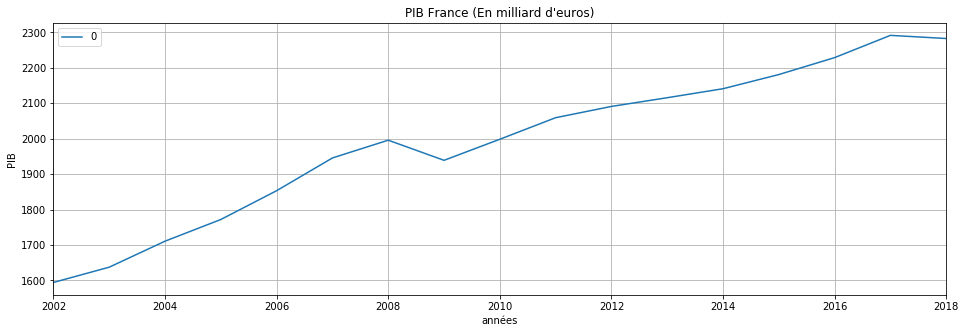

In [23]:
df_pib = pd.DataFrame.from_dict(get_pib(), orient='index')

fig, ax = plt.subplots(1, figsize=(16, 5))

df_pib.plot(ax=ax)
plt.grid()
plt.title("PIB France (En milliard d'euros)")
plt.xlabel('années')
plt.ylabel('PIB')

plt.show()

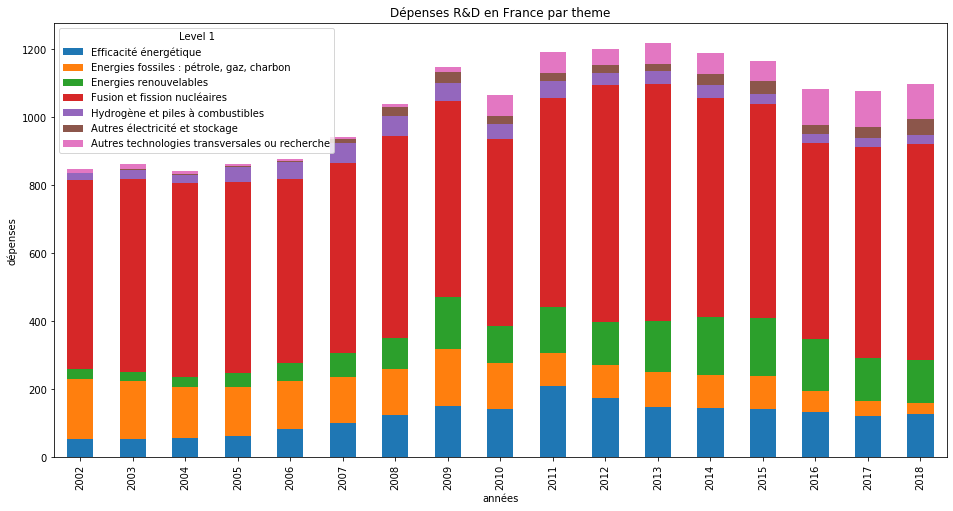

In [24]:
fig, axes = plt.subplots(1, figsize=(16,8))

df_trans = df_l1.set_index('Level 1').transpose()

df_trans.drop(['Budget total'], axis=1, inplace=True)

plt.title("Dépenses R&D en France par theme",)
plt.xlabel('années')
plt.ylabel('dépenses')

df_trans.plot(ax= axes, kind='bar', stacked=True);

### => On note une croissance relative 

In [25]:
df_zoom = df_trans[df_trans.columns[1:4]]

dico = {'Energies fossiles : pétrole, gaz, charbon': 'Energies fossiles',
        'Energies renouvelables': 'Energies renouvelables',
        'Fusion et fission nucléaires': 'Energies nucléaires'}

df_zoom = df_zoom.rename(columns=dico)

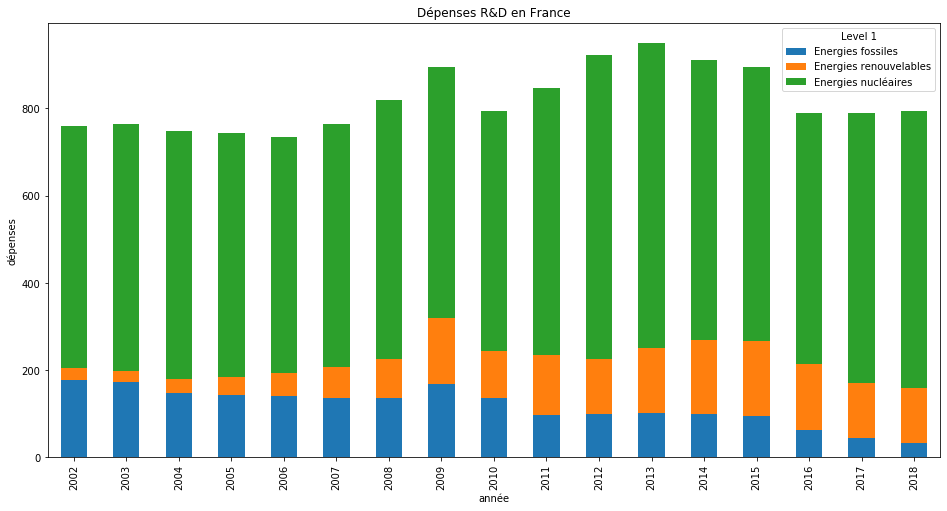

In [26]:
fig, axes = plt.subplots(1, figsize=(16,8))

plt.title("Dépenses R&D en France")
plt.xlabel('année')
plt.ylabel('dépenses')

df_zoom.plot(ax= axes, kind='bar', stacked=True)

In [27]:
# Select details renewables
df_l2 = df2[(df2['is_level2'] == True)].copy()

df_l2 = df_l2.drop(['Level 3', 'Level 4'], axis=1)

In [28]:
df_renouv = df_l2[df_l2['Level 1']=='Energies renouvelables'].copy()

df_renouv.drop('Level 1', inplace=True, axis=1)

In [29]:
df_transp_renouv = df_renouv[df_renouv.columns[:18]].set_index('Level 2').transpose()

df_transp_renouv.drop(['Non alloué', 'Autres'], axis=1, inplace=True)

#df_transp_renouv.to_excel('NRJ renouvelables zoom.xlsx')

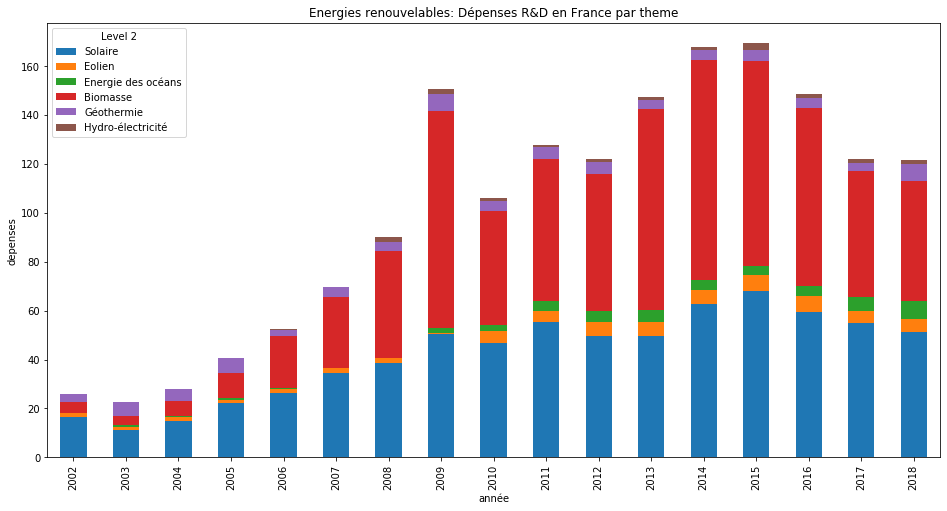

In [30]:
#df_trans['Energies renouvelables'].to_parquet('NRJ renouvelables')
fig, axes = plt.subplots(1, figsize=(16,8))

plt.title("Energies renouvelables: Dépenses R&D en France par theme")
plt.xlabel('année')
plt.ylabel('depenses')

df_transp_renouv.plot(ax= axes, kind='bar', stacked=True)

plt.show()

### Comparaison de la répartition des dépenses dans les énergies renouvelables

Text(0.5, 1.0, '2018')

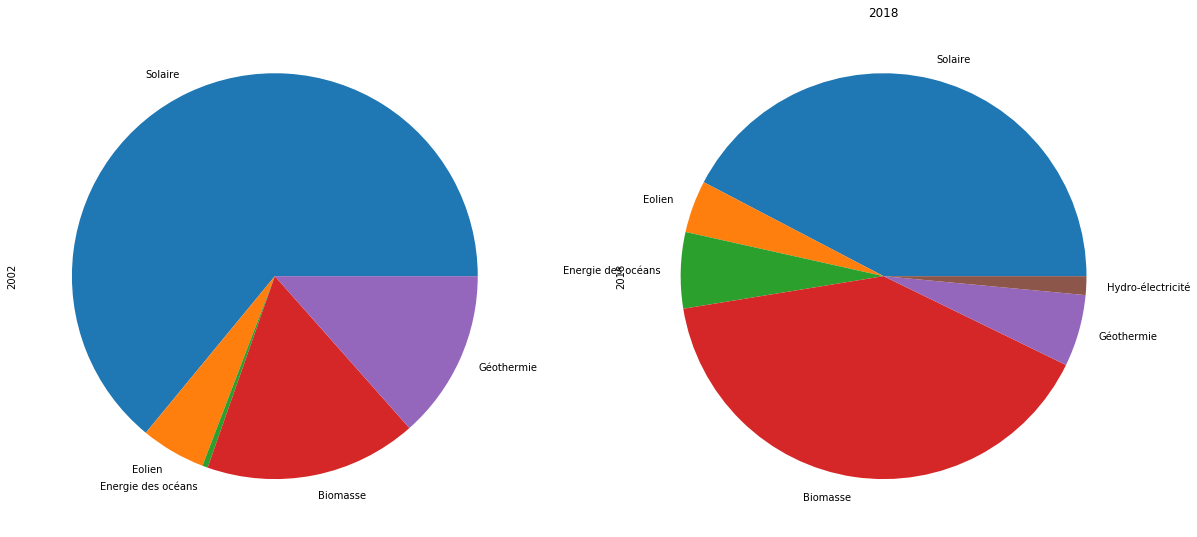

In [35]:

df_transp_renouv_pie = df_renouv[df_renouv.columns[:18]].set_index('Level 2')

df_transp_renouv_pie.drop(['Non alloué', 'Autres'], axis=0, inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(20,20))
    
df_transp_renouv_pie.plot.pie(y='2002',
                              ax=axes[0], legend=False)
plt.title('2002')

df_transp_renouv_pie.plot.pie(y='2018',
                              ax=axes[1], legend=False)
plt.title('2018')


## 3. Corrélation Energies Renouvelables

In [37]:
dfRD = pd.read_excel('data/NRJ renouvelables zoom.xlsx')[:17]
dfRD.rename(columns={'Unnamed: 0':'Année'}, inplace=True)
dfRD.set_index('Année', inplace=True)

In [38]:
annees = np.arange(2002, 2019).reshape(-1,1)
anneeRef = 2002

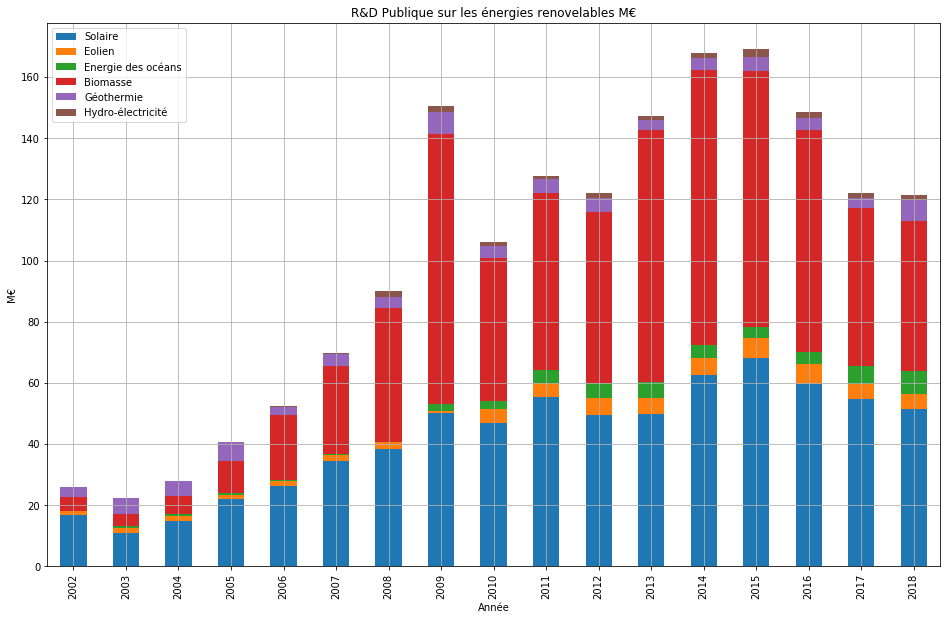

In [39]:
fig, ax = plt.subplots(1, figsize=(16, 10))

dfRD.plot(ax=ax, kind='bar', stacked=True)
ax.set_xlabel('Année')
ax.set_ylabel('M€')
ax.set_title("R&D Publique sur les énergies renovelables M€")
ax.grid()

plt.show()

In [40]:
dfSelectionRD = dfRD[['Biomasse', 'Hydro-électricité', 'Solaire', 'Eolien']]
refRD = dfSelectionRD.loc[anneeRef:anneeRef].values
indiceRD2002 = dfSelectionRD.values / refRD
dfIndiceRD2002 = pd.DataFrame(np.hstack((annees, indiceRD2002)))
dfIndiceRD2002.columns = dfSelectionRD.reset_index().columns
dfIndiceRD2002.set_index('Année', inplace=True)

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


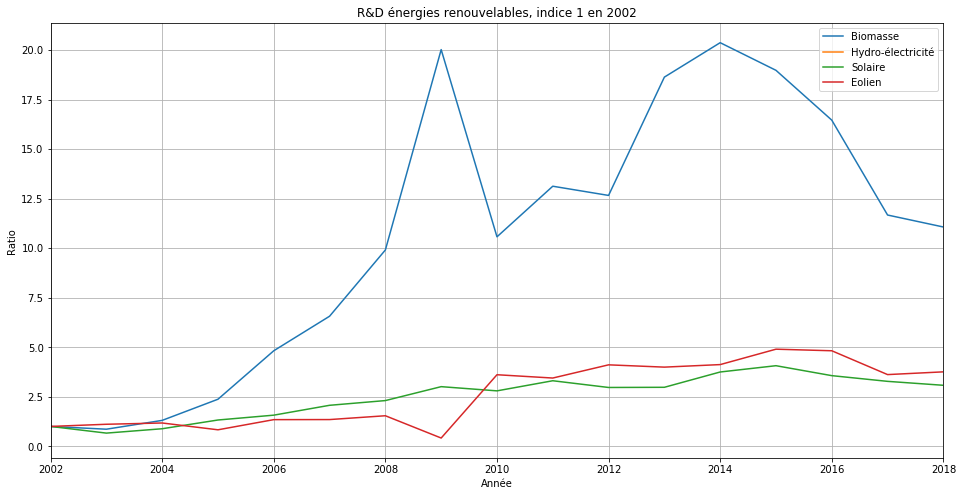

In [41]:
fig, ax = plt.subplots(1, figsize=(16, 8))
dfIndiceRD2002.plot(ax=ax)
ax.set_xlabel('Année')
ax.set_ylabel('Ratio')
ax.set_title("R&D énergies renouvelables, indice 1 en %d" % anneeRef)
ax.grid()

### Production énergie renouvelables

In [42]:
dfProdConso = pd.read_csv('data/prodconso_renouvelable.csv')

dfProdConso.rename(columns={'Unnamed: 0': 'Année',
                            "Consommation finale d'énergies renouvelables thermiques et déchets, tous usages confondus": 'Biomasse et déchets'},
                   inplace=True)

dfProdConso = dfProdConso[dfProdConso['Année'] >= 2002].set_index('Année')

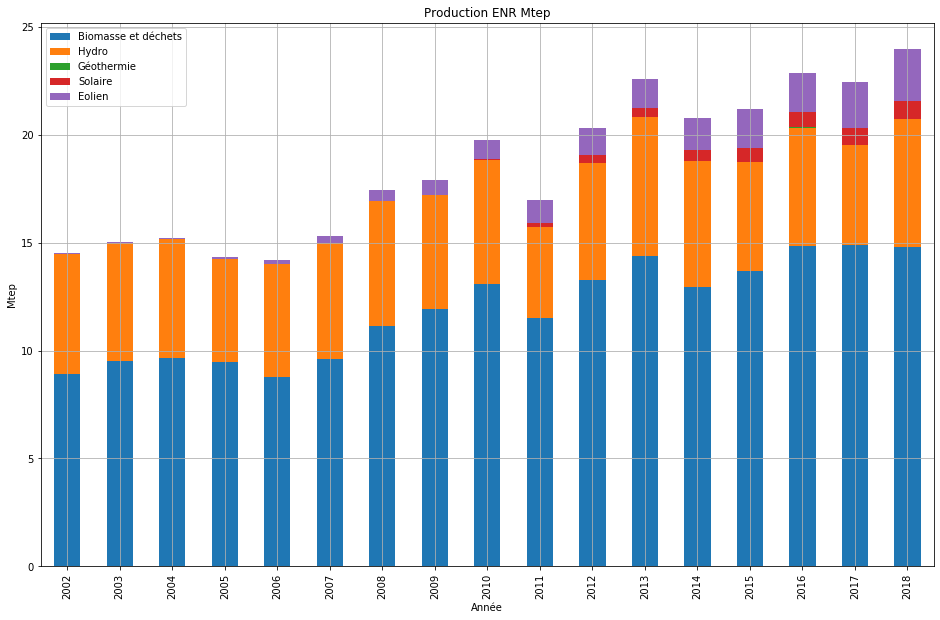

In [43]:
fig, ax = plt.subplots(1, figsize=(16, 10))

dfProdConso.plot(ax=ax, kind='bar', stacked=True)
ax.set_xlabel('Année')
ax.set_ylabel('Mtep')
ax.set_title("Production ENR Mtep")
ax.grid()

plt.show()

In [44]:
dfSelectionProd = dfProdConso[['Biomasse et déchets', 'Hydro', 'Solaire', 'Eolien']]

refProd = dfSelectionProd.loc[anneeRef:anneeRef].values
prodIndice2002 = dfSelectionProd.values - refProd

dfProdIndice2002 = pd.DataFrame(np.hstack((annees, prodIndice2002)))

dfProdIndice2002.columns = dfSelectionProd.reset_index().columns
dfProdIndice2002.set_index('Année', inplace=True)

# dfProdIndice2002.head()

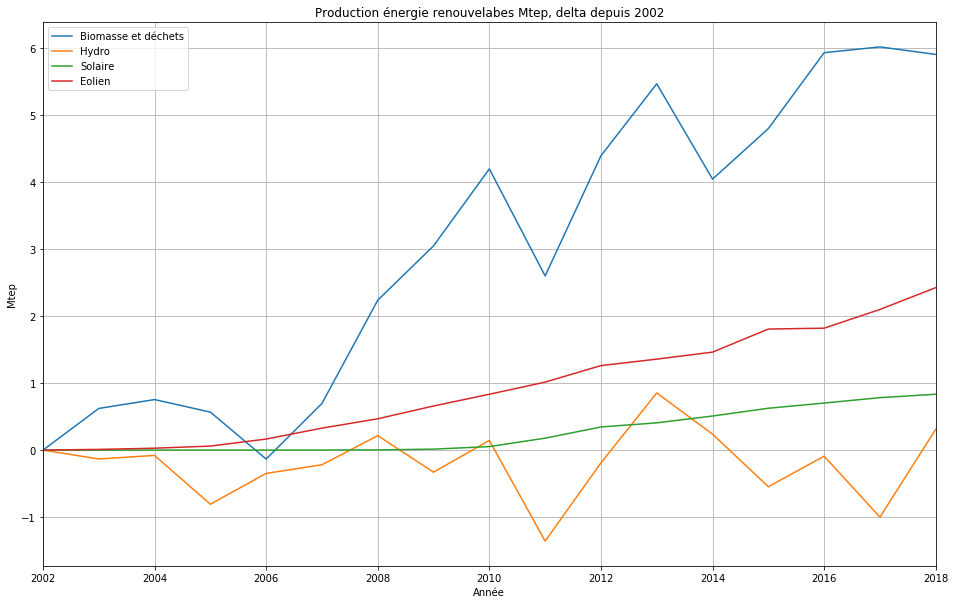

In [45]:
fig, ax = plt.subplots(1, figsize=(16, 10))

dfProdIndice2002.plot(ax=ax)

ax.set_xlabel('Année')
ax.set_ylabel('Mtep')
ax.set_title("Production énergie renouvelabes Mtep, delta depuis %d" % anneeRef)
ax.grid()

## Convolution sur les valeurs

In [46]:
i = 0
valRD = dfSelectionRD.values
valProd = dfSelectionProd.values - refProd
n = valRD.shape[0]
p = valRD.shape[1]
d = n
correlateAbs = np.ones((d, p))
for i in range(p):
    correlateAbs[:, i] = np.convolve(valRD[:, i], valProd[:, i], mode='same')

In [47]:
dd = correlateAbs / valRD
dd[np.isinf(dd)] = np.nan

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [48]:
dfCorrelateAbs = pd.DataFrame(dd)
dfCorrelateAbs.columns = dfProdIndice2002.columns

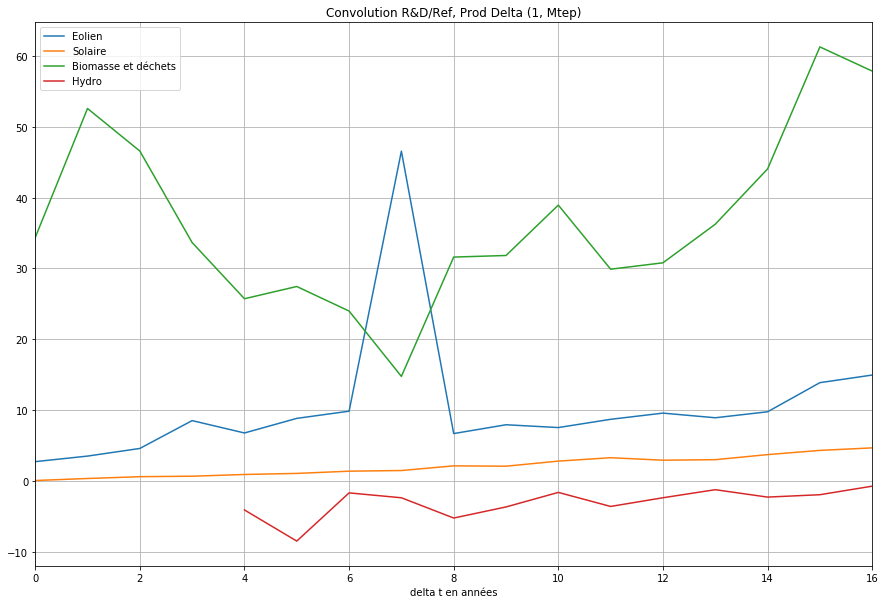

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
dfCorrelateAbs[['Eolien',  'Solaire',
                'Biomasse et déchets', 'Hydro']].plot(ax=ax)
ax.set_title('Convolution R&D/Ref, Prod Delta (1, Mtep)')
ax.set_xlabel('delta t en années')
ax.grid()